### Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)

### Повторить п.2, но используя уже не медиану, а max

импортируем библиотеки:

In [1]:
#!pip install razdel pymorphy2

In [2]:
import pandas as pd
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, 
                             confusion_matrix)
import re
import numpy as np
np.seterr(divide='ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath

from razdel import tokenize 
import pymorphy2 
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


качаем файлы:

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2023-03-20 15:41:59--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Resolving docs.google.com (docs.google.com)... 142.251.16.101, 142.251.16.100, 142.251.16.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.16.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ikm9rtpbrp6257h6m05ql5bfkj5ot0e2/1679326875000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=a5440b8f-c07e-4bde-b497-1db6acb70065 [following]
--2023-03-20 15:42:00--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ikm9rtpbrp6257h6m05ql5bfkj5ot0e2/1679326875000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=a5440b8f-c07e-4bde-b497-1db6acb70065
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 172.253.62.132, 

ниже код для реализации LDA-модели:

In [4]:
def word_processing(df):
    '''обработка текста'''

    def clean_text(text):
        '''очистка текста, на выходе очищеный текст'''
        
        if not isinstance(text, str):
            text = str(text)
        text = text.lower()
        text = text.strip('\n').strip('\r').strip('\t')
        text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
        text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
        text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
        text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
        text = re.sub('n', ' ', text)
        return text

    cache = {}
    morph = pymorphy2.MorphAnalyzer()

    def lemmatization(text):    
        '''лемматизация, на выходе лист лемматизированых токенов'''

        # w - стоп-слова
        w = stopwords.words('russian')
        with open('stopwords.txt') as f:
            additional_stopwords = [w.strip() for w in f.readlines() if w]
        w += additional_stopwords 
        
        # если зашел тип не `str` делаем его `str`
        if not isinstance(text, str):
            text = str(text)
        # токенизация предложения через razdel
        tokens = list(tokenize(text))
        words = [_.text for _ in tokens]

        words_lem = []
        for w in words:
            if w[0] == '-': # проверка есть ли в начале слова '-'
                w = w[1:]
            if len(w) > 1: # проверка токена с одного символа
                if w in cache: # проверка есть ли данное слово в кэше
                    words_lem.append(cache[w])
                else: # лемматизация слова
                    temp_cach = cache[w] = morph.parse(w)[0].normal_form
                    words_lem.append(temp_cach)
        # проверка на стоп-слова:
        words_lem_without_stopwords = [i for i in words_lem if not i in w] 
        return words_lem_without_stopwords
    df['title'] = df['title'].progress_apply(lambda x: clean_text(x))
    df['title'] = df['title'].progress_apply(lambda x: lemmatization(x))

    return df['title']

In [5]:
def trained_model(df, N_topic=20, passes=2):
    '''создание модели'''
    
    # сформируем список наших текстов
    texts = list(news['title'].values)
    # Создадим корпус из списка с текстами
    common_dictionary = Dictionary(texts)
    common_corpus = [common_dictionary.doc2bow(text) for text in texts]
    # Обучаем модель на корпусе
    lda = LdaModel(common_corpus, num_topics=N_topic, 
                   id2word=common_dictionary, passes=passes)
    # Сохраняем модель на диск
    temp_file = datapath("model.lda")
    lda.save(temp_file)
    # Загружаем обученную модель с диска
    return common_dictionary, LdaModel.load(temp_file)

In [6]:
def documents_to_vector(df, lda, common_dictionary, N_topic=15):
    '''функция возвращает датафрейм из вероятностей новостей'''

    def get_lda_vector(lda, text):
        '''функция возвращает векторное представление новости'''
        
        unseen_doc = common_dictionary.doc2bow(text)
        lda_tuple = lda[unseen_doc]

        not_null_topics = dict(zip([i[0] for i in lda_tuple], 
                                  [i[1] for i in lda_tuple]))
        output_vector = []
        for i in range(N_topic):
            if i not in not_null_topics:
                output_vector.append(0)
            else:
                output_vector.append(not_null_topics[i])
        return np.array(output_vector)

    topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in df['title'].values])
    topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
    topic_matrix['doc_id'] = df['doc_id'].values
    topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
    return topic_matrix


In [7]:
def check_their_quality(target, topic_matrix, N_topic=15, FUNC=np.mean):
    '''функция получает эмбединги для всех пользователей и проверяет их качество на конкретной downstream-задаче'''

    def get_user_embedding(user_articles_list, doc_dict, func):
        user_articles_list = eval(user_articles_list)
        user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
        user_vector = func(user_vector, axis=0)
        return user_vector

    doc_dict = dict(zip(topic_matrix['doc_id'].values, 
                    topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))
    
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, FUNC))])
    user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

    X = pd.merge(user_embeddings, target, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)
    model = LogisticRegression()
    # обучим 
    model.fit(X_train, y_train)

    preds = model.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_test, preds)
    best_threshold, f_score, precision = thresholds[ix], fscore[ix], precision[ix]
    recall, roc_auc = recall[ix], roc_auc
    #print(f'{best_threshold=:.4f}, {f_score=:.4f}, {precision=:.4f}, {recall=:.4f}, {roc_auc=:.4f}')

    return model, preds, best_threshold, f_score, precision, recall, roc_auc

In [14]:
# долго
def calculation_of_metrics_and_graphics(news, FUNC=np.mean):
    if FUNC == 'max':
        FUNC = np.max
    elif FUNC == 'median':
        FUNC = np.median
    else:
        FUNC = np.mean
    
    for p in range(1, 6, 2):
        best_threshold_list, f_score_list, precision_list = [], [], [] 
        recall_list, roc_auc_list = [], [] 
        th, fs, pr, rc, ra = 0, 0, 0, 0, 0
        print(f'количество проходов = {p}')
        for i in range(5, 25, 5):

            # создаём LDA-модель    
            common_dictionary, lda = trained_model(news, N_topic=i, passes=p)
            
            # формируем матрицу вероятностей для новостей
            topic_matrix = documents_to_vector(news, lda, common_dictionary, N_topic=i)

            # собираем метрики
            model, preds, best_threshold, f_score, precision, recall, roc_auc = \
            check_their_quality(target, topic_matrix, N_topic=i, FUNC=FUNC)

            if math.isnan(best_threshold):
                best_threshold = 0
            if math.isnan(f_score):
                f_score = 0
            if math.isnan(precision):
                precision = 0
            if math.isnan(recall):
                recall = 0
            if math.isnan(roc_auc):
                roc_auc = 0
            best_threshold_list.append(best_threshold)
            f_score_list.append(f_score)
            precision_list.append(precision)
            recall_list.append(recall)
            roc_auc_list.append(roc_auc)
            if np.max(best_threshold_list) > th:
                th = np.max(best_threshold_list)
            if np.max(f_score_list) > fs:
                fs = np.max(f_score_list)
            if np.max(precision_list) > pr:
                pr = np.max(precision_list)
            if np.max(recall_list) > rc:
                rc = np.max(recall_list)
            if np.max(roc_auc_list) > ra:
                ra = np.max(roc_auc_list)

        plt.figure(figsize=(15, 6))
        plt.plot(best_threshold_list, label=f'best_threshold={th:.2f}')
        plt.plot(f_score_list, label=f'f_score={fs:.2f}')
        plt.plot(precision_list, label=f'precision={pr:.2f}')
        plt.plot(recall_list, label=f'recall={rc:.2f}')
        plt.plot(roc_auc_list, label=f'roc_auc={ra:.2f}')
        plt.legend()
        plt.xticks(range(4), range(5, 25, 5))
        plt.xlabel('количество тем')
        plt.grid(linestyle=':')
        plt.title(f'метрики при количестве проходов = {p} и FUNC = {FUNC.__name__}', 
                  fontweight='bold', fontsize=15)

_____
_____

загружаем файлы:

In [9]:
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")
target = pd.read_csv("users_churn.csv")

подготавливаем текст:

In [10]:
news['title'] = word_processing(news)

100%|██████████| 27000/27000 [03:19<00:00, 135.24it/s]


строим графики, смотрим метрики. Начинаем с FUNC='mean'

количество проходов = 1
количество проходов = 3
количество проходов = 5


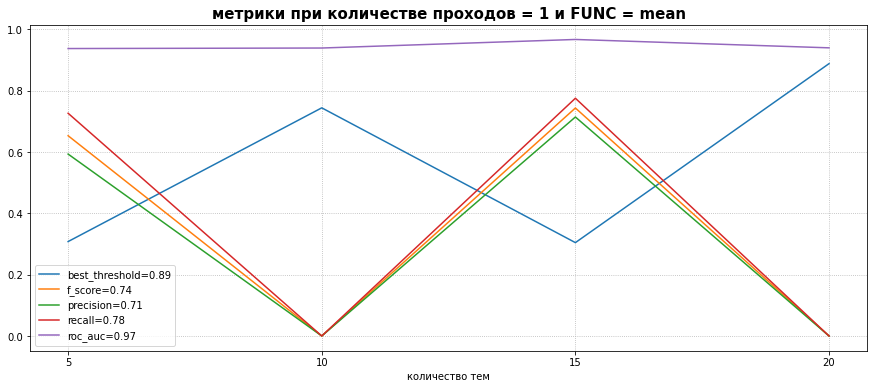

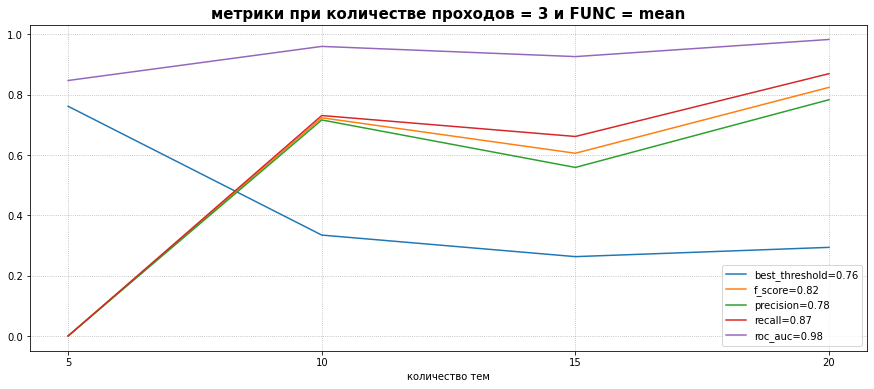

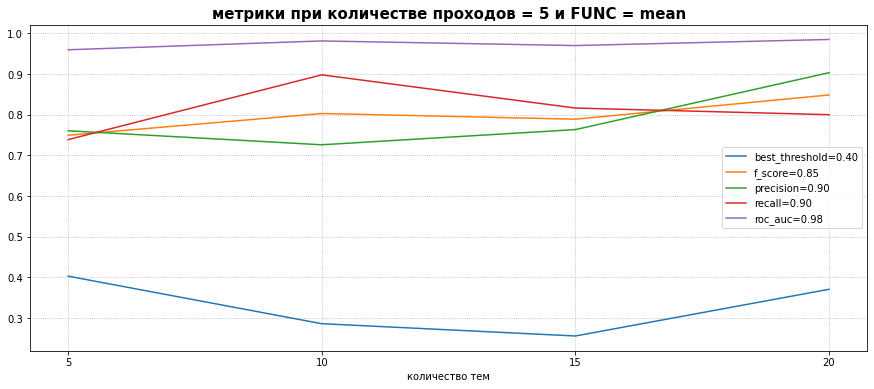

In [15]:
calculation_of_metrics_and_graphics(news, FUNC='mean')

Лучшие ```precision=0.9```, ```recall=0.9```, ```F-score=0.85``` при ```FUNC=mean``` и 5-ти проходах

Теперь с FUNC='median'

количество проходов = 1
количество проходов = 3
количество проходов = 5


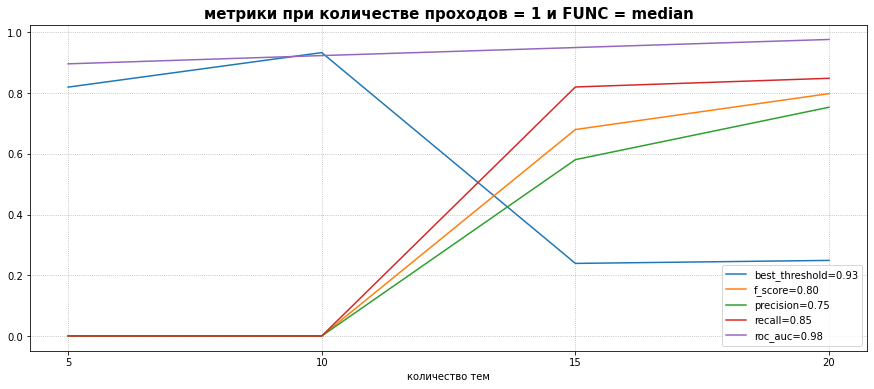

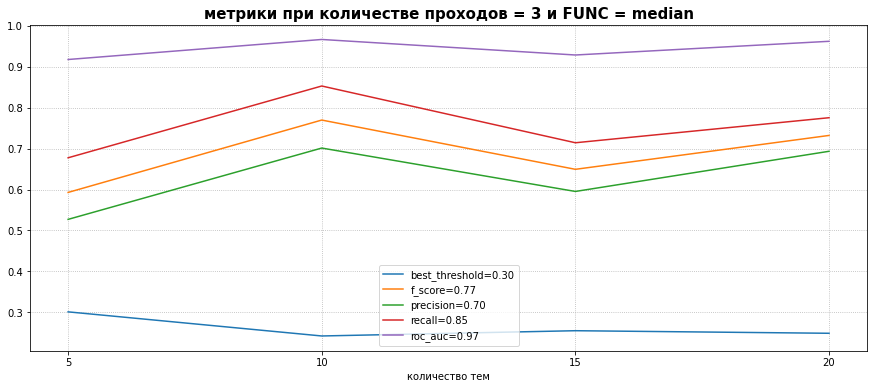

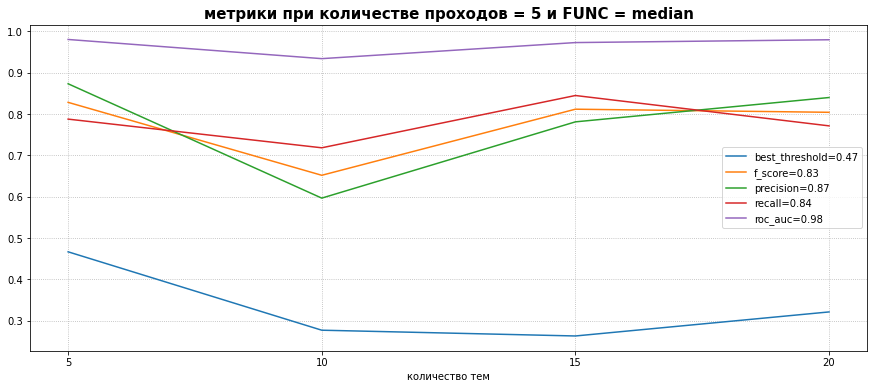

In [16]:
calculation_of_metrics_and_graphics(news, FUNC='median')

При ```FUNC=median``` алгоритм отработал чуть хуже - при 5-ти проходах ```precision=0.87```, ```recall=0.84```, ```F-score=0.83``` 

количество проходов = 1
количество проходов = 3
количество проходов = 5


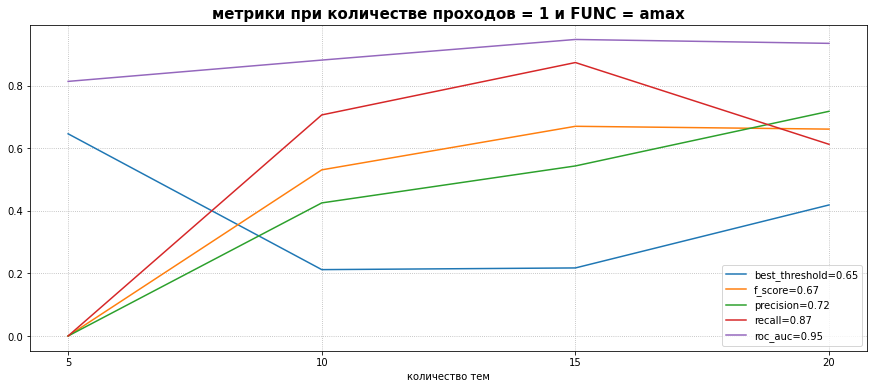

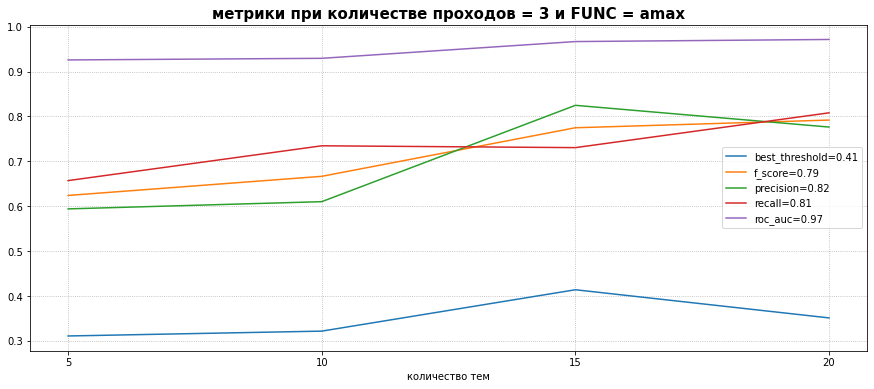

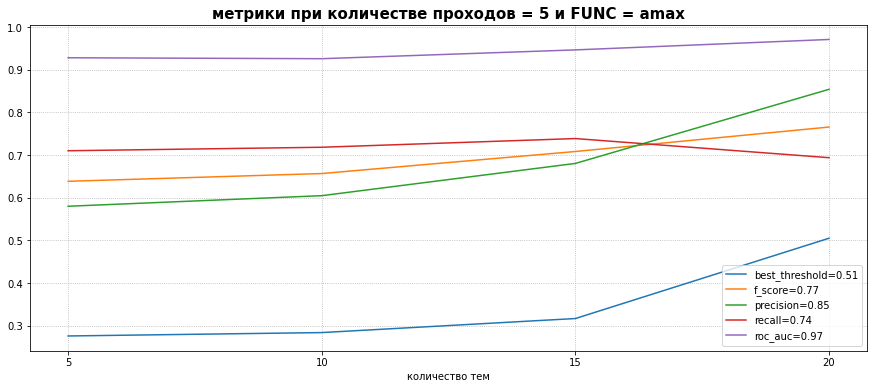

In [20]:
calculation_of_metrics_and_graphics(news, FUNC='max')

При ```FUNC=max``` алгоритм показал себя хуже всего, при этом лучшие значения метрик при 3-х проходах: ```precision=0.82```, ```recall=0.81```, ```F-score=0.79``` 